# AICE Professional 시험 준비하면서 작성했던 코드에 주석을 달았습니다.

1. Tabular 데이터 Brain stroke prediction dataset
- 데이터 출처 : https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
2. Text 데이터 Twitter Sentiment
- 데이터 출처 : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
3. Img 데이터 Flower_Classification_5class
- 데이터 출처 : https://www.kaggle.com/datasets/sauravagarwal/flower-classification

In [ ]:
# 라이브러리 임포트
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
# 딥러닝 라이브러리 임포트
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# AICE Professional-1 Tabular 데이터 분류 모델 만들기

In [ ]:
# Tabular traindata.csv 불러오기
# df = pd.read_csv('full_data_training.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_training.csv')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
# Tabular 데이터 정보 확인
# 위의 df와 비교하면서 값하고 Dtype이 다른 부분이 있는지 확인
# 결측치 확인, 데이터 컬럼의 용도 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [ ]:
# Tabular 데이터 전처리 - 라벨 인코딩
df['gender'] = np.where(df['gender']=='Male', 1, 0)
df['ever_married'] = np.where(df['ever_married']=='Yes', 1, 0)

In [ ]:
# Tabular 데이터 전처리 - 결측치 확인
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩, object인 데이터만 분류
obj_col = df.select_dtypes('object').columns
obj_col

Index(['work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩
df = pd.get_dummies(data=df, columns=obj_col, drop_first=True)

In [ ]:
# Tabular 데이터 컬럼 변경사항 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 feature, label 분류
features = df.drop('stroke', axis=1)
labels = df['stroke']

In [ ]:
#label
labels.value_counts()

,count
stroke,
0,4733
1,248


In [ ]:
# Tabular 데이터 Train, valid 데이터셋 분할

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((3984, 14), (997, 14), (3984,), (997,))

In [ ]:
# 라이브러리 임포트
"""
머신러닝 분류 모델의 경우 아래의 것들이 성능이 좋았어서 이것들만 사용했습니다.
LogisticRegression 이 연산 속도가 빨라서 먼저 실행해보고서 어느정도의 성능이 나오는지 보고
성능이 부족한거 같으면 RandomForestClassifier와 DecisionTreeClassifier를 사용했습니다.
딥러닝 분류 모델도 만들어서 모델 성능을 비교하고 마지막에 골라서 제출했습니다.
머신러닝 회귀 모델의 경우 DecisionTreeRegressor, RandomForestRegressor, 딥러닝 CNN 모델만 사용했습니다.
"""
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Tabular LogisticRegression 머신러닝 모델 분류 성능 확인
lgr = LogisticRegression()
lgr.fit(x_train, y_train)
lgr.score(x_valid, y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9498495486459378

In [ ]:
# Tabular SGDClassifier 머신러닝 모델 분류 성능 확인
sgdc = SGDClassifier()
sgdc.fit(x_train, y_train)
sgdc.score(x_valid, y_valid)

0.9017051153460381

In [ ]:
# Tabular DecisionTreeClassifier 머신러닝 모델 분류 성능 확인
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc.score(x_valid, y_valid)

0.9037111334002006

In [ ]:
# Tabular RandomForestClassifier 머신러닝 모델 분류 성능 확인
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_valid, y_valid)

0.9468405215646941

In [ ]:
# Tabular 딥러닝 모델
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[-1], )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) #저는 2개 분류~여러개 분류 모두 softmax로 통일해서 사용했습니다.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Tabular 딥러닝 모델 compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tabular 딥러닝 모델 훈련 fit
# Tabular는 es, mc, history에 숫자를 붙이지 않고 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5457 - loss: 0.8668
Epoch 1: val_loss improved from inf to 0.30950, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5465 - loss: 0.8655 - val_accuracy: 0.9498 - val_loss: 0.3095
Epoch 2/10
113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3780
Epoch 2: val_loss improved from 0.30950 to 0.25438, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3744 - val_accuracy: 0.9498 - val_loss: 0.2544
Epoch 3/10
109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9310 - loss: 0.2706
Epoch 3: val_loss improved from 0.25438 to 0.19375, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.2682 - val_accuracy: 0.9498 - val_loss: 0.1938
Epoch 4/10
115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.2296
Epoch 4: val_loss improved from 0.19375 to 0.18133, 

In [ ]:
# Tabular test 데이터셋.csv 읽기
#df5 = pd.read_csv('full_data_validation.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_validation.csv')
df5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.555602,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.242937,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.698951,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.808410,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.378534,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
196,Male,41.0,0,0,No,Private,Rural,70.15,29.756631,formerly smoked,0
197,Male,40.0,0,0,Yes,Private,Urban,191.15,31.124172,smokes,0
198,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.798304,smokes,0
199,Male,40.0,0,0,Yes,Private,Rural,83.94,29.951301,smokes,0


In [ ]:
"""
위의 train, valid 데이터와 동일하게 대부분 데이터 전처리를 수행합니다.
훈련 데이터 셋에서는 중복, 결측치를 제거해서 모델의 분류 성능을 올려야 하지만,
테스트 데이터셋의 갯수를 줄이는 것은 (중복 삭제, 결측치 제거)는 하면 안됩니다.
저는 실습하다가 무의식적으로 하다가 지운 경우가 많았던거 같습니다.
"""
# Tabular test 데이터 전처리 - 라벨 인코딩
df5['gender'] = np.where(df5['gender']=='Male', 1, 0)
df5['ever_married'] = np.where(df5['ever_married']=='Yes', 1, 0)
df5.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular Test 데이터 전처리 - 원 핫 인코딩
obj_col2 = df5.select_dtypes('object').columns
df5 = pd.get_dummies(data=df5, columns=obj_col2, drop_first=True)

In [ ]:
# Tabular Test 데이터 feature, label 분류
x_test = df5.drop('stroke', axis=1)
y_test = df5['stroke']

In [ ]:
# Tabular Test 데이터로 머신러닝, 딥러닝 모델 성능 예측
lgr_y_pred = lgr.predict(x_test)
sgdc_y_pred = sgdc.predict(x_test)
dtc_y_pred = dtc.predict(x_test)
rfc_y_pred = rfc.predict(x_test)
model_y_pred = model.predict(x_test)
model_y_pred = np.argmax(model_y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [ ]:
lgr_y_pred, sgdc_y_pred, dtc_y_pred, rfc_y_pred, model_y_pred, model_y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0,

In [ ]:
"""
시험에서는 TestDataset에 대한 라벨이 부여되지 않아 아래와 같이 확인이 가능하지 않습니다.
현재 테스트 데이터셋은 라벨도 있고, 모델 성능이 비슷해보여서 비교하는 과정을 가졌습니다.

LogisticRegression 훈련 데이터셋 성능: 0.9498 (95%)
SGDClassifier 훈련 데이터셋 성능: 0.9498 (95%)
DecisionTreeClassifier 훈련 데이터셋 성능: 0.9067 (91%)
RandomForestClassifier 훈련 데이터셋 성능: 0.9478 (95%)
딥러닝 모델 훈련 데이터셋 성능: 0.9498 (95%)

시험 환경이었다면 모델성능이 비슷하다고 느껴지면
다른 실습 과정에서도 대부분 좋은 성능을 내는건 아래의 두 모델이라
RandomForestClassifier, 딥러닝 모델중 하나를 제출했을거 같습니다.

"""

In [ ]:
# Tabular 데이터 분류 시각화
from sklearn.metrics import classification_report, confusion_matrix

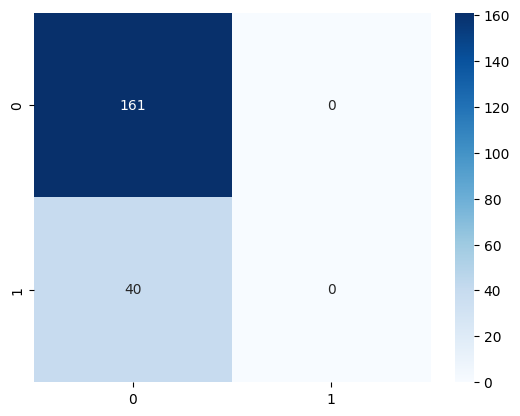

In [ ]:
# Logistic Regression 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, lgr_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

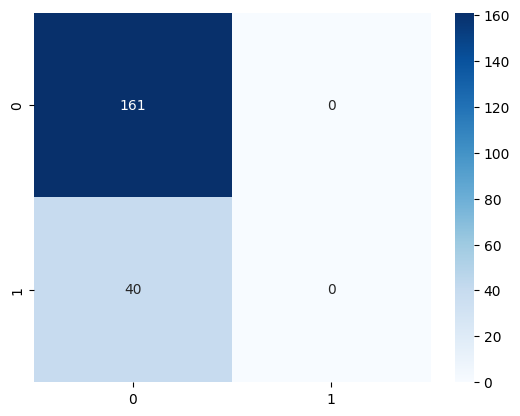

In [ ]:
# SGDC Classifier 모델 성능 - 훈련이 잘못된거 같아요.
cm = confusion_matrix(y_test, sgdc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

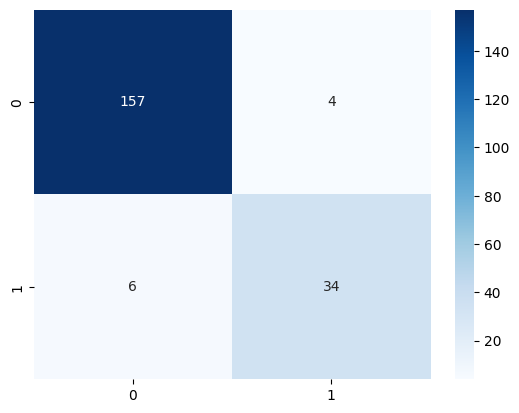

In [ ]:
# DecisionTreeClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다.
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

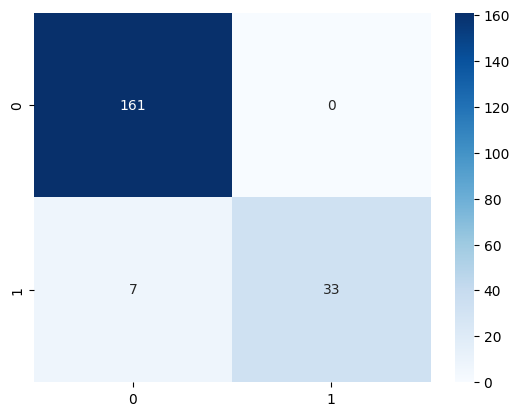

In [ ]:
# RandomForestClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다. DecisionTree와 비슷한 성능인거 같네요.
cm = confusion_matrix(y_test, rfc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

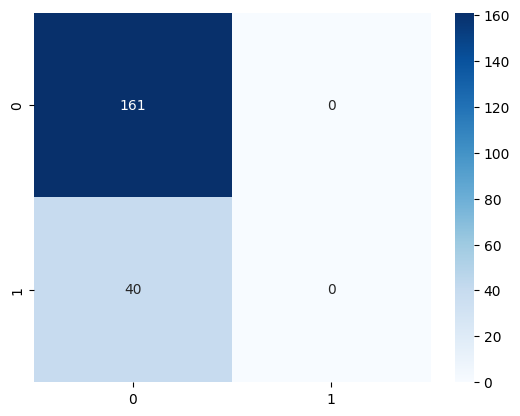

In [ ]:
# 딥러닝 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, model_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# 모델중에 가장 성능이 좋아보이는 DecisionTreeClassifier의 예측값을 테스트 데이터셋 csv에 추가
df5['pred'] = rfc_y_pred
df5

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


In [ ]:
# 테스트 데이터셋 모델 성능 확인 - 안해도 되는 작업이지만 라벨이 있어서 한번 더 확인해봤습니다.
correct_count = sum(df5['stroke']==df5['pred'])
total_count = len(df5)
model_accuracy = correct_count/total_count
print(f'model_accuracy : {model_accuracy:.2f}')

model_accuracy : 0.97


In [ ]:
# Tabular 머신러닝 모델 저장을 위한 joblib 라이브러리 임포트
import joblib
joblib.dump(rfc, '01012345678_1.joblib') # Tabular 데이터는 '연락처_1.joblib' 으로 저장

['01012345678_1.joblib']

In [ ]:
import joblib
joblib.dump(rfc, '01088139716.joblib')

In [ ]:
# Tabular 모델 저장 확인
tab_load_model = joblib.load('01012345678_1.joblib')

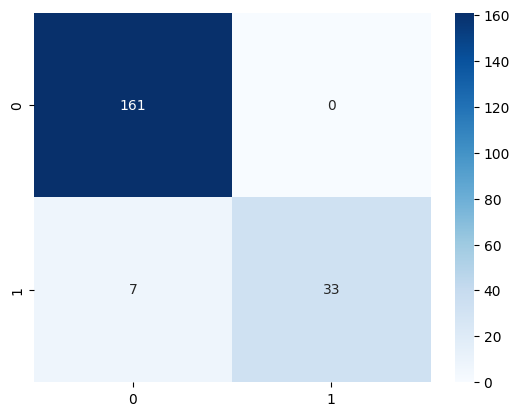

In [ ]:
# Tabular 모델 불러와서 모델 성능 확인 / 시험에서는 불필요
tab_load_y_pred = tab_load_model.predict(x_test)
cm = confusion_matrix(y_test, tab_load_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Tabular 모델 테스트 데이터셋.csv 저장
df5.to_csv('01012345678_1.csv', index=False, encoding='utf-8') # Tabular 데이터는 '연락처_1.csv' 으로 저장
df6 = pd.read_csv('01012345678_1.csv') # 데이터 저장 확인
df6

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


# AICE Professional-2 Text 분류 모델 만들기

In [ ]:
# Text train 데이터.csv 읽기
# column이 없는 데이터셋이라 header를 None으로 하고 임의로 라벨을 지정해서 사용할 예정입니다.
#text_df = pd.read_csv('twitter_training.csv', header=None)
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

text_df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/twitter_training.csv', header=None)
text_df

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:

# Text 데이터 전처리 - 감정 분류에 불필요한 데이터셋 제거
text_df = text_df.drop([0, 1], axis=1)

In [ ]:
# Text 데이터 전처리 - column 임의로 지정 label, text
text_df = text_df.rename(columns={2:'label', 3:'text'})
text_df

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [ ]:
# Text 데이터 전처리 - 결측치 확인
text_df.isnull().sum()

,0
label,0
text,686


In [ ]:
# Text 데이터 전처리 - 결측치 확인
text_df = text_df.dropna()

In [ ]:
# Text 데이터 전처리 - 불용어 여부 확인
# '[^a-zA-Z ]' 으로 적으면 소문자, 대문자, 공백 제외 다른 문자나 숫자가 있는지 확인
# '[^가-힣 ]' 으로 적으면 한글, 공백 제외 다른 문자나 숫자가 있는지 확인
# '[^a-zA-Z가-힣 ]' 으로 적으면 영문, 한글, 공백 제외
# [^a-zA-Z가-힣] <- 공백이 없이 만들면 이후 작업에서 띄어쓰기에 필요한 공백을 모두 제거해버려서 문제가 됩니다.

text_df[text_df['text'].str.contains('[^a-zA-Z ]')].head(3)

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


In [ ]:
# Text 영문자 제외 모두 ''으로 변경
text_df['text'] = text_df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
# Text 문자열의 앞뒤 공백을 제거
text_df['text'] = text_df['text'].str.strip()
# Text 소문자로 변경
text_df['text'] = text_df['text'].str.lower()
# Text 중복 여부 확인 / 6997개 인 것 확인
text_df['text'].duplicated().sum()

<ipython-input-46-4ef7be13015a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text'] = text_df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
<ipython-input-46-4ef7be13015a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text'] = text_df['text'].str.strip()
<ipython-input-46-4ef7be13015a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

np.int64(6997)

In [ ]:
# Text 중복 제거
text_df.drop_duplicates(subset='text', inplace=True)

<ipython-input-47-8fbce50339b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.drop_duplicates(subset='text', inplace=True)


In [ ]:
# Text 중복 제거 확인
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66999 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   66999 non-null  object
 1   text    66999 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
# Text 라벨이 어떤 종류가 있는지 확인
text_df['label'].value_counts()

,count
label,
Negative,20455
Positive,18215
Neutral,16519
Irrelevant,11810


In [ ]:
# Text 라벨 인코딩
text_class_to_label = {'Negative':0, 'Positive':1, 'Neutral':2, 'Irrelevant':3}
text_df['label'] = text_df['label'].map(text_class_to_label)

<ipython-input-50-6d2bea400fac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['label'] = text_df['label'].map(text_class_to_label)


In [ ]:
# Text 라벨 인코딩 제대로 되었는지 확인
text_df['label'].value_counts()

,count
label,
0,20455
1,18215
2,16519
3,11810


In [ ]:
# Text feature, label 분류
text_features = text_df['text']
text_labels = text_df['label']

In [ ]:
# Text train, valid 데이터셋 나누기
text_x_train, text_x_valid, text_y_train, text_y_valid = train_test_split(text_features, text_labels, test_size=0.2, random_state=42, stratify=text_labels)
text_x_train.shape, text_x_valid.shape, text_y_train.shape, text_y_valid.shape

((53599,), (13400,), (53599,), (13400,))

In [ ]:
# Text 분류, TFIDF-머신러닝 모델로 분류하기
# 사용방법이 비교적 단순하고 전처리도 거의 없어서 먼저 해봅니다.
# TF-IDF는 텍스트가 포함된 벡터의 특성에 따라 각 단어의 가중치를 계산하고,
# 그 가중치를 이용해 문서나 텍스트를 분류하거나 회귀 모델에 입력으로 사용합니다.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_x_train_v = tfidf.fit_transform(text_x_train)
text_x_valid_v = tfidf.transform(text_x_valid)

In [ ]:
# Text LogisticRegression 모델 성능 확인
text_lgr = LogisticRegression()
text_lgr.fit(text_x_train_v, text_y_train)
text_lgr.score(text_x_valid_v, text_y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7642537313432836

In [ ]:
# Text SGDClassifer 모델 성능 확인
text_sgdc = SGDClassifier()
text_sgdc.fit(text_x_train_v, text_y_train)
text_sgdc.score(text_x_valid_v, text_y_valid)

0.7161940298507463

In [ ]:
# Text DecisionTreeClassifier 모델 성능 확인
text_dtc = DecisionTreeClassifier()
text_dtc.fit(text_x_train_v, text_y_train)
text_dtc.score(text_x_valid_v, text_y_valid)

0.7198507462686567

In [ ]:
# Text RandomForestClassifier 모델 성능 확인
text_rfc = RandomForestClassifier()
text_rfc.fit(text_x_train_v, text_y_train)
text_rfc.score(text_x_valid_v, text_y_valid)

0.9085820895522388

In [ ]:
# Text Tokenizer - 딥러닝 분석을 위한 라이브러리 임포트
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Text Tokenizer 작업
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_x_train)

In [ ]:
# Tokenizer에 학습한 단어가 어떤게 있는지 확인용입니다. 작성하지 않아도 괜찮아요.
print(tokenizer.word_index)

In [ ]:
# Tokenizer에 학습한 단어별 빈도 수 확인용입니다. 작성하지 않아도 괜찮아요.
print(tokenizer.word_counts)

In [ ]:
# Tokenizer가 학습한 단어의 개수를 확인합니다.
max_words = len(tokenizer.word_index)
max_words

35958

In [ ]:
# Tokenizer 시퀀스 작업
text_x_train_seq = tokenizer.texts_to_sequences(text_x_train)
text_x_valid_seq = tokenizer.texts_to_sequences(text_x_valid)

In [ ]:
# Tokenizer 시퀀스 작업 후 가장 긴 문장의 단어 개수를 찾습니다.
max(len(i) for i in text_x_train_seq)

166

In [ ]:
# Tokenizer 시퀀스 이후 pad 작업을 하여 가장 긴 문장의 단어수에 맞춰서 공백을 0으로 채워줍니다.
text_x_train_pad = pad_sequences(text_x_train_seq, maxlen=166)
text_x_valid_pad = pad_sequences(text_x_valid_seq, maxlen=166)

In [ ]:
# Text label 갯수 확인용 (4개)
text_labels.value_counts()

,count
label,
0,20455
1,18215
2,16519
3,11810


In [ ]:
# Text 딥러닝 모델
text_model = Sequential()
text_model.add(Embedding(input_dim=max_words+1, output_dim=100, input_length=166))
text_model.add(Bidirectional(LSTM(16, return_sequences=True)))
text_model.add(Dropout(0.3))
text_model.add(Bidirectional(LSTM(16, return_sequences=False)))
text_model.add(Dropout(0.3))
text_model.add(Dense(64, activation='swish'))
text_model.add(BatchNormalization())
text_model.add(Dropout(0.3))
text_model.add(Dense(4, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Text 딥러닝 모델 compile
text_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Text는 es2, mc2, history2 처럼 변수에 2를 붙여서 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
mc2 = ModelCheckpoint('best_text_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history2 = text_model.fit(
    text_x_train_pad, text_y_train,
    epochs=5,
    batch_size=512,
    validation_data=(text_x_valid_pad, text_y_valid),
    callbacks=[es2, mc2],
    verbose=1
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4364 - loss: 1.2234
Epoch 1: val_loss improved from inf to 1.25177, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.4376 - loss: 1.2216 - val_accuracy: 0.5882 - val_loss: 1.2518
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8288 - loss: 0.4851
Epoch 2: val_loss improved from 1.25177 to 0.96368, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8290 - loss: 0.4846 - val_accuracy: 0.7831 - val_loss: 0.9637
Epoch 3/5
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9267 - loss: 0.2259
Epoch 3: val_loss improved from 0.96368 to 0.57318, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9267 - loss: 0.2259 - val_accuracy: 0.8449 - val_loss: 0.5732
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9445 - loss: 0.1625
Epoch 4: val_loss improved from 0.5

In [ ]:
# 위의 Text 모델 성능은 0.873이 나왔네요.
# Text Test 데이터셋.csv 불러오기
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

text_df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/twitter_validation.csv', header=None)
text_df5

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
# Text Test 데이터셋 전처리 - 불필요한 column 삭제, 결측치 확인
text_df5 = text_df5.drop([0, 1], axis=1)
text_df5 = text_df5.rename(columns={2:'label', 3:'text'})
text_df5.isnull().sum()

,0
label,0
text,0


In [ ]:
# Text Test 데이터셋 전처리 - 불용어 여부 확인
text_df5[text_df5['text'].str.contains('[^a-zA-Z ]')].head(3)

,label,text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...


In [ ]:
# Text Test 데이터셋 불용어 제거
text_df5['text'] = text_df5['text'].str.replace('[^a-zA-Z ]', '', regex=True)
# Text Test 데이터셋 앞뒤에 공백 제거
text_df5['text'] = text_df5['text'].str.strip()
# Text Test 데이터셋 소문자로 변경
text_df5['text'] = text_df5['text'].str.lower()
# Text Test 데이터셋 중복 여부, 갯수 확인
text_df5['text'].duplicated().sum()

# Train Data와 다르게 Test 데이터셋은 중복이 있어도 지우지 않았습니다.

np.int64(3)

In [ ]:
# Text Test 데이터셋 라벨 종류, 갯수 확인
text_df5['label'].value_counts()

,count
label,
Neutral,285
Positive,277
Negative,266
Irrelevant,172


In [ ]:
# Text Test 데이터셋 라벨 인코딩, 제대로 되었는지 확인 (Train 데이터셋하고 동일하게)
text_class_to_label = {'Negative':0, 'Positive':1, 'Neutral':2, 'Irrelevant':3}
text_df5['label'] = text_df5['label'].map(text_class_to_label)
text_df5['label'].value_counts()

,count
label,
2,285
1,277
0,266
3,172


In [ ]:
# Text Test 데이터셋 feature, label 분류
text_x_test = text_df5['text']
text_y_test = text_df5['label']
# Text Test 데이터 모델 성능 확인을 위해 데이터 전처리, Tfidf, Tokenizer
text_x_test_v = tfidf.transform(text_x_test)
text_x_test_seq = tokenizer.texts_to_sequences(text_x_test)
text_x_test_pad = pad_sequences(text_x_test_seq)

In [ ]:
# Text Test 데이터셋 모델로 예측하기.
text_rfc_y_pred = text_rfc.predict(text_x_test_v)
text_model_y_pred = text_model.predict(text_x_test_pad)
text_model_y_pred = np.argmax(text_model_y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


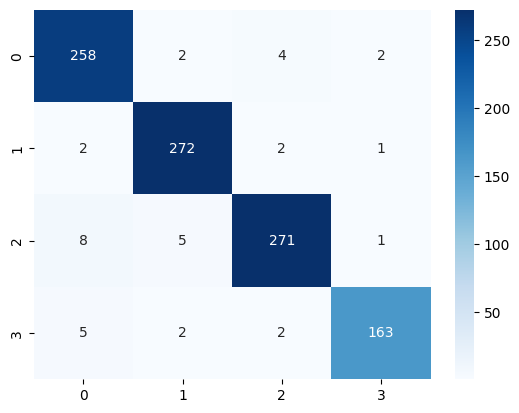

In [ ]:
# Text Test 데이터셋에 label이 있어서 예측한 것과 비교용으로 시각화 하였습니다.
# 시험에서는 label이 없기 때문에 확인할 수 없습니다.
# Text RandomForestClassifier 모델
text_cm = confusion_matrix(text_y_test, text_rfc_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

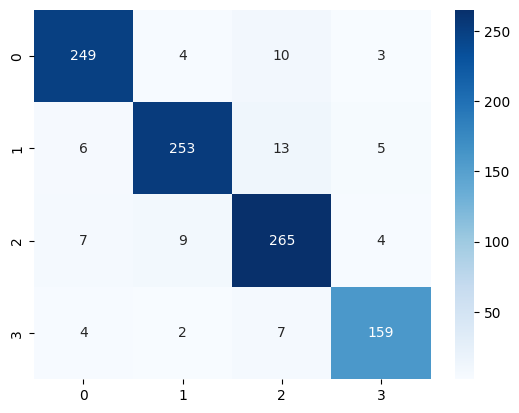

In [ ]:
# Text 딥러닝 모델
text_cm = confusion_matrix(text_y_test, text_model_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Text RandomForestClassifier는 훈련 데이터셋 기준 0.908
# Text 딥러닝은 훈련 데이터셋 기준 0.873이 나와서 RandomForest 모델을 선택했습니다.
# Text 데이터 라벨이 4개인 분류인데 96% 성능이면 꽤 좋은거 같습니다.
# 위에서도 말씀드렸지만, Test Dataset에 라벨이 있기 때문에 예측값과 비교한 부분입니다.
# 시험에서는 불필요한 부분입니다.

text_df5['pred'] = text_rfc_y_pred
text_correct_count = sum(text_df5['label']==text_df5['pred'])
text_total_count = len(text_df5)
text_model_accuracy = text_correct_count/text_total_count
print(f'text_model_accuracy : {text_model_accuracy:.2f}')

text_model_accuracy : 0.96


In [ ]:
# Text dataset에 예측한 값을 csv에 추가
text_df5['pred'] = text_rfc_y_pred
text_df5

,label,text,pred
0,3,i mentioned on facebook that i was struggling ...,3
1,2,bbc news amazon boss jeff bezos rejects claim...,2
2,0,microsoft why do i pay for word when it functi...,0
3,0,csgo matchmaking is so full of closet hacking ...,0
4,2,now the president is slapping americans in the...,2
...,...,...,...
995,3,toronto is the arts and culture capital of can...,3
996,3,this is actually a good move tot bring more vi...,3
997,1,today sucked so its time to drink wine n play ...,1
998,1,bought a fraction of microsoft today small wins,1


In [ ]:
# Text dataset 라벨 인코딩 했던 것 원상태로
text_label_to_class = {0:'Negative', 1:'Positive', 2:'Neutral', 3:'Irrelevant'}
text_df5['label'] = text_df5['label'].map(text_label_to_class)
text_df5['pred'] = text_df5['pred'].map(text_label_to_class)
text_df5

,label,text,pred
0,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant
1,Neutral,bbc news amazon boss jeff bezos rejects claim...,Neutral
2,Negative,microsoft why do i pay for word when it functi...,Negative
3,Negative,csgo matchmaking is so full of closet hacking ...,Negative
4,Neutral,now the president is slapping americans in the...,Neutral
...,...,...,...
995,Irrelevant,toronto is the arts and culture capital of can...,Irrelevant
996,Irrelevant,this is actually a good move tot bring more vi...,Irrelevant
997,Positive,today sucked so its time to drink wine n play ...,Positive
998,Positive,bought a fraction of microsoft today small wins,Positive


In [ ]:
# Text Test 데이터셋.csv 저장 및 불러와서 확인
text_df5.to_csv('01012345678_2.csv', index=False, encoding='utf-8')
text_df6 = pd.read_csv('01012345678_2.csv')
text_df6

,label,text,pred
0,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant
1,Neutral,bbc news amazon boss jeff bezos rejects claim...,Neutral
2,Negative,microsoft why do i pay for word when it functi...,Negative
3,Negative,csgo matchmaking is so full of closet hacking ...,Negative
4,Neutral,now the president is slapping americans in the...,Neutral
...,...,...,...
995,Irrelevant,toronto is the arts and culture capital of can...,Irrelevant
996,Irrelevant,this is actually a good move tot bring more vi...,Irrelevant
997,Positive,today sucked so its time to drink wine n play ...,Positive
998,Positive,bought a fraction of microsoft today small wins,Positive


In [ ]:
# Text RandomForestClassifier 모델 저장
joblib.dump(text_rfc, '01012345678_2.joblib')

['01012345678_2.joblib']

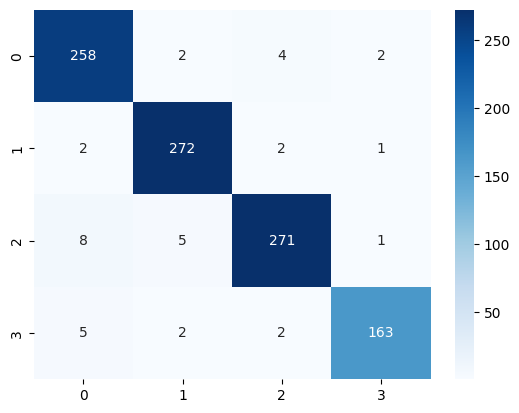

In [ ]:
# Text 모델 저장 잘 되었는지 불러와서 성능 확인
text_load_model = joblib.load('01012345678_2.joblib')
text_load_y_pred = text_load_model.predict(text_x_test_v)
text_cm = confusion_matrix(text_y_test, text_load_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

# AICE Professional-3 Image 분류 모델 만들기

In [ ]:
# github img 데이터셋 불러오기
!wget https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip

--2025-03-31 13:31:07--  https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip [following]
--2025-03-31 13:31:07--  https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229731827 (219M) [application/zip]
Saving to: ‘Flower_Classification_5class.zip’

Flower_Classificati 100%[===================>] 219.09M   264MB/s    in 0.8s    

2025-03-31 13:31:35 

In [ ]:
# Colab 환경에서 압축 파일 업로드했기에 사용한 부분입니다.
!unzip Flower_Classification_5class.zip -d /content/

In [ ]:
# 시험에서는 압축을 별도로 풀지 않고 train과 test 이미지 경로를 바로 사용할 수 있도록 경로를 제공해줍니다.
# 예시1 : /content/flowers/train/
# 예시2 : /content/flowers/valid/

# img flower_photos에 데이터셋 종류 확인
!ls -l /content/flowers/flowers/flower_photos

total 12
drwxr-xr-x 7 root root 4096 Mar 31 13:32 test
drwxr-xr-x 7 root root 4096 Mar 31 13:32 train
drwxr-xr-x 7 root root 4096 Mar 31 13:32 validation


In [ ]:
# img jpg, jpeg, png, gif 뭐가 있는지 확인
# 다른 데이터셋중에는 jpg, jpeg가 혼합되어 사용된 경우가 있었어서 확인하게 되었습니다.
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpeg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep png | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep gif | wc -l

607
0
0
0


In [ ]:
# img valid 데이터셋 폴더내 꽃 종류 확인
!ls -l /content/flowers/flowers/flower_photos/validation

total 20
drwxr-xr-x 2 root root 4096 Mar 31 13:32 daisy
drwxr-xr-x 2 root root 4096 Mar 31 13:32 dandelion
drwxr-xr-x 2 root root 4096 Mar 31 13:32 roses
drwxr-xr-x 2 root root 4096 Mar 31 13:32 sunflowers
drwxr-xr-x 2 root root 4096 Mar 31 13:32 tulips


In [ ]:
# img test 데이터셋 폴더내 daisy 갯수 및 이미지 풀네임 확인
!ls -l /content/flowers/flowers/flower_photos/test/daisy

total 396
-rw-r--r-- 1 root root 36410 Apr 18  2021 10172379554_b296050f82_n.jpg
-rw-r--r-- 1 root root 24463 Apr 18  2021 1306119996_ab8ae14d72_n.jpg
-rw-r--r-- 1 root root 31422 Apr 18  2021 134409839_71069a95d1_m.jpg
-rw-r--r-- 1 root root 24030 Apr 18  2021 19813618946_93818db7aa_m.jpg
-rw-r--r-- 1 root root 17466 Apr 18  2021 3338077096_3a8ed0e2bc_m.jpg
-rw-r--r-- 1 root root 15072 Apr 18  2021 3552074420_2a0a7166db_m.jpg
-rw-r--r-- 1 root root 70320 Apr 18  2021 4141147800_813f660b47.jpg
-rw-r--r-- 1 root root 43385 Apr 18  2021 538920244_59899a78f8_n.jpg
-rw-r--r-- 1 root root 40516 Apr 18  2021 5973488341_50bdf6cee3_n.jpg
-rw-r--r-- 1 root root 86338 Apr 18  2021 8446495985_f72d851482.jpg


In [ ]:
# img train, valid 경로 지정
train_img_path = '/content/flowers/flowers/flower_photos/train/'
valid_img_path = '/content/flowers/flowers/flower_photos/validation/'

In [ ]:
"""
지금은 train 데이터셋, valid 데이터셋이 제공되어서 train-train, valid-valid를 사용했습니다.
train 데이터셋 하나만 제공되는 경우에는 valid 데이터셋을 만들기 위해서는
directory, validation_split, subset을 아래처럼 수정해주시면 됩니다.

train
directory=train_img_path,
validation_split=0.2,
subset='training'

valid
directory=train_img_path,
validation_split=0.2,
subset='validation'

"""

# img train dataset 만들기
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='training'
)
# img valid dataset 만들기
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='validation'
)

Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.


In [ ]:
# img 사전학습 모델인 MobileNetV3Large 사용
# 이미지 사이즈는 사전 학습된 모델 호환성 – 많은 딥러닝 모델(VGG16, ResNet 등)이
# 224x224 크기의 이미지를 입력으로 사용하도록 학습되었기 때문에 이렇게 사용했습니다.
img_base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3), weights='imagenet', include_top=False)
img_base_model.trainable=False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# img dataset의 라벨 갯수 확인용 (5개)
train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# img 딥러닝 모델 제작
img_model = Sequential()
img_model.add(img_base_model)
img_model.add(Flatten())
img_model.add(Dense(256, activation=None))
img_model.add(BatchNormalization())
img_model.add(Activation('relu'))
img_model.add(Dropout(0.5))
img_model.add(Dense(5, activation='softmax'))

In [ ]:
#img 딥러닝 모델 compile
img_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# img 딥러닝 모델 훈련 fit
# img는 es3, mc3, history3 처럼 변수에 3을 붙여서 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc3 = ModelCheckpoint('best_img_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history3 = img_model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[es3, mc3],
    verbose=1
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7627 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.45077, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.7633 - loss: 0.6887 - val_accuracy: 0.8750 - val_loss: 0.4508
Epoch 2/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9672 - loss: 0.1219
Epoch 2: val_loss improved from 0.45077 to 0.32265, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9673 - loss: 0.1216 - val_accuracy: 0.9125 - val_loss: 0.3227
Epoch 3/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9937 - loss: 0.0397
Epoch 3: val_loss improved from 0.32265 to 0.30810, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9937 - loss: 0.0396 - val_accuracy: 0.9125 - val_loss: 0.3081
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9976 - loss: 0.0248
Epoch 4: val_loss did not imp

In [ ]:
# 시험에서는 csv 파일에 image 파일명이 제공되지만,
# 현재의 환경처럼 csv 파일이 없는 경우 시험 환경과 비슷하게 하기 위해 파일을 만드는 부분입니다.
# 시험에서는 이 부분은 사용하지 않으셔도 될겁니다.

img_glob = sorted(glob.glob('/content/flowers/flowers/flower_photos/test/*/*jpg'))
img_file = [os.path.basename(path) for path in img_glob]
img_label = [os.path.basename(os.path.dirname(path)) for path in img_glob]

# img Test 데이터셋을 이용해서 DataFrame 만들기
img_df5 = pd.DataFrame()
img_df5['image'] = img_glob
img_df5['file'] = img_file
img_df5['label'] = img_label
img_df5.head(10)

,image,file,label
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy


In [ ]:
# img train dataset 라벨이 어떤게 들어있는지 확인
# imagedataset labels='inferred'를 설정해서 만들었기 때문에 a-z순으로 자동 저장됩니다.
# label의 순서를 임의로 조정해야한다면, 위의 imagedataset labels=None, Class_names=['cats', 'dogs']를 적으시면 됩니다.

train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# 예측값 저장용 변수
img_predictions = []
# img test 데이터셋 폴더 경로
img_folder = '/content/flowers/flowers/flower_photos/test/'
# test 데이터셋 라벨 인코딩용 변수
img_label_to_class = {
    0:'daisy',
    1:'dandelion',
    2:'roses',
    3:'sunflowers',
    4:'tulips'
}

"""
시험에서는 csv를 '파일 경로+이미지'가 아니라 '이미지명'만 줬던거로 기억합니다.
img_folder 경로를 지정하고 img_path = os.path.join(img_folder, row['file'])
즉 폴더 경로 + 이미지명.jpg로만 사용해서 시험에서는 분류가 가능하지만
현재의 테스트 데이터셋은 Test/Daisy/이미지 상태로
시험의 테스트 데이터셋은 Test/이미지
와 다르게 꽃의 이름과 같은 하위 폴더가 있어서, 임의로 만든 row['image']이미지의 모든 경로를 사용합니다.

1. 위의 코드인 이미지의 경로를 확인해서 테스트 데이터셋 img_df5.csv를 만드는 방법
2. 이미지 폴더경로 + 이미지명 / img_df5['file'] 분류
3. 이미지 모든경로 / img_df5['image']로 분류
2번 방법만 알아도 시험을 보는데는 문제가 없을거로 생각되지만 변경사항이 있을 수 있으니
모두 다 사용방법을 다 숙달하고 외워서 가시는걸 추천드립니다.
이거는 다른거처럼 문법 레퍼런스를 보고 사용하는게 불가능해서 중점적으로 코드 연습을 했던 부분입니다.

"""

# 이미지를 한개씩 띄우고 예측한 값과 이미지명을 알려줍니다.
# img_df5.csv 기준 위에서 부터 순서대로 모델을 예측하고 분류해줍니다.
for i, row in img_df5.iterrows():
  img_path = row['image']
  #img_path = os.path.join(img_folder, row['file'])
  img = tf.keras.utils.load_img(img_path, target_size=(224,224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  img_pred_t = img_model.predict(img_array, verbose=0)
  img_pred_label = np.argmax(img_pred_t)
  img_pred_class = img_label_to_class.get(img_pred_label, 'None')
  img_predictions.append(img_pred_label)

  plt.imshow(img)
  plt.title(f'Predict : {img_pred_label}({img_pred_class}) \n {os.path.basename(img_path)}')
  plt.axis('off')
  plt.show()

In [ ]:
# img 모델의 예측값을 csv파일에 추가해줍니다.
img_df5['pred'] = img_predictions
img_df5.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,0
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,0
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,0
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,0
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,0
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,0
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,0
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,0
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,0
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,0


In [ ]:
# img 예측한 값의 라벨을 수정해줍니다.
img_df5['pred'] = img_df5['pred'].map(img_label_to_class)
img_df5.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,daisy


In [ ]:
# img 모델의 성능은 0.86이 나왔네요
# 시험에서는 테스트 데이터셋의 라벨이 없기 때문에 불필요한 부분입니다.
img_correct_count = sum(img_df5['label']==img_df5['pred'])
img_total_count = len(img_df5)
img_model_accuracy = img_correct_count/img_total_count
print(f'img_model_accuracy : {img_model_accuracy:.2f}')

img_model_accuracy : 0.86


In [ ]:
# img 테스트 데이터셋.csv를 저장합니다.
img_df5.to_csv('01012345678_3.csv', index=False, encoding='utf-8')
img_df6 = pd.read_csv('01012345678_3.csv')
img_df6.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,daisy


In [ ]:
# img 딥러닝 모델을 저장해줍니다.
img_model.save('01012345678_3.h5')

In [ ]:
# 수고하셨습니다! 코드 내용과 csv, 모델 저장등을 검토 하고서 최종 제출 누르시면 됩니다.
